# Network Running and Training

@[Chaoming Wang](mailto:adaduo@outlook.com)

To maker your model powerful, you need to train your created network models. In this section, we are going to talk about how to train and run your network models.

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

In [2]:
import matplotlib.pyplot as plt

## RNN structural runner ``RNNRunner``

For a feedforward network, predicting the output of the network just needs to call the instantiated model:

```python
model = ... # your created model

output = model(inputs)
```

To accelerate the model running, you can jit the model by

```python

import brainpy.math as bm
model = bm.jit(model)  # jitted model

output = model(inputs)
```

However, for the recurrent network model, you need to call the instantiated model multiple times along the time axis. However, looping in python is very inefficient. Instead, BrainPy provides structural runner ``brainpy.nn.RNNRunner`` for the recurrent neural network running. Using ``brainpy.nn.RNNRunner``, the looping process will be jit compiled into machine code, approaching to the speed of native c++ code.

Here we have a reservoir model.

In [3]:
model = (bp.nn.Input(3) >>
         bp.nn.Reservoir(100) >>
         bp.nn.LinearReadout(3))
model.initialize()

And we have a Lorenz attractor data.

In [4]:
lorenz = bp.datasets.lorenz_series(100)
data = bm.hstack([lorenz['x'], lorenz['y'], lorenz['z']])

Our task is to predict the Lorenz data 5 time step ahead.

In [5]:
X, Y = data[:-5], data[5:]

Note, all ``nn`` models in BrainPy must have a batch axis at the first dimension of the data.

In [6]:
# here batch size is 1
X = bm.expand_dims(X, axis=0)
Y = bm.expand_dims(Y, axis=0)

X.shape

(1, 99995, 3)

We can output the model predictions according to the input data simply with

In [7]:
runner = bp.nn.RNNRunner(model, jit=True)

predictions = runner.predict(X)
predictions.shape

  0%|          | 0/99995 [00:00<?, ?it/s]

(1, 99995, 3)

In [8]:
bp.losses.mean_squared_error(predictions, Y)

DeviceArray(260.12122, dtype=float32)

Without training, the mean squared error (MSE) between the prediction and the target is large. We need to train the network hoping it has the ability to produce the correct results.

## Supported training algorithms

Currently, BrainPy provides several kinds of methods to train recurrent neural networks, including

- offline training algorithms, like ridge regression,
- online training algorithms, like FORCE learning,
- back-propagation based algorithms, like BPTT, etc.

The full list of the supported training algorithms please see the [API documentation](../apis/auto/nn/runners.rst). Here we only talk about few of them.

## RNN structural trainer ``RNNTrainer``

``RNNTrainer`` is a structural trainer to train recurrent neural networks. Actually, it is a subclass of ``RNNRunner``. What's different from ``RNNRunner`` is that the former has one more function ``.fit()`` to train the model.

The **training data** feeding into the ``.fit()`` function can be a tuple/list of ``(X, Y)`` pair, or a callable function which generate ``(x, y)`` data pairs.

- If the providing training data is the ``(X, Y)`` data pair, ``X`` should be the input data which has the shape of `(num_sample, num_time, ...)`, ``Y`` should be the target data which has the shape of `(num_sample, ...)`.
- If the training data is a callable function, it should generate a Python generator which yield the pair of ``(X, Y)`` data for training. For example,

```python

# when calling this function,
# it will create a Python generator.

def train_data():
  num_data = 10
  for _ in range(num_data):
     # The (X, Y) data pair should be:
     # - "X" is a tensor has the shape of
     #   "(num_batch, num_time, num_feature)"
     # - "Y" is a tensor has the shape of
     #   "(num_batch, num_time, num_feature)"
     #   or "(num_batch, num_feature)"
     xs = bm.random.rand(1, 20, 2)
     ys = bm.random.random((1, 20, 2))
     yield xs, ys
```

However, all these data constraints can be released when you customize your training procedures. Please see [Customization of a Network Training](./training_customization.ipynb).

## Offline training algorithms

Offline learning means you train your network with all dataset at once. All supported offline learning algorithms are

In [9]:
bp.nn.algorithms.get_supported_offline_methods()

('ridge', 'linear', 'lstsq')

We will continue to update all offline learning methods. New advances please check the corresponding [API documentation](../apis/auto/nn/algorithms.rst)

Instantiating an offline learning method is simple. Once you have your network model, like the above reservoir model, you just need to provide this model into the ``brainpy.nn.OfflineTrainer`` as

In [10]:
model = (bp.nn.Input(3) >>
         bp.nn.Reservoir(100) >>
         bp.nn.LinearReadout(3))
model.initialize()

In [11]:
trainer = bp.nn.OfflineTrainer(
    model,
    fit_method=bp.nn.algorithms.RidgeRegression(beta=1e-6)
    # or
    # fit_method=dict(name='ridge', beta=1e-6)
)

trainer

OfflineTrainer(target=Network(LinearReadout1, Input1, Reservoir1), 
	              jit={'fit': True, 'predict': True}, 
	              fit_method=RidgeRegression(beta=1e-06))

Let's train the created model with the Lorenz attractor data series.

In [12]:
trainer.fit([X, Y])

  0%|          | 0/99995 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/99995 [00:00<?, ?it/s]

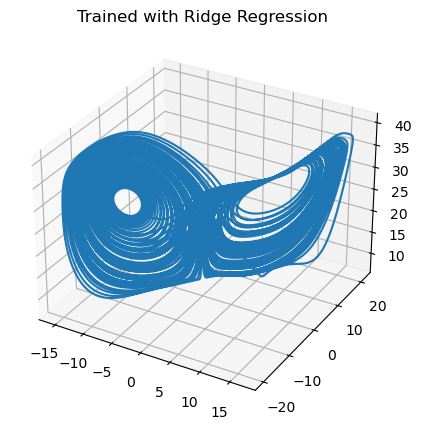

In [13]:
predict = trainer.predict(X, reset=True)
predict1 = bm.as_numpy(predict)

fig = plt.figure(figsize=(5, 5))
fig.add_subplot(111, projection='3d')
plt.plot(predict1[0, :, 0], predict1[0, :, 1], predict1[0, :, 2])
plt.title('Trained with Ridge Regression')
plt.show()

## Online training algorithms

BrainPy also supports flexible online training methods. Online learning means you train the model from a sequence of data instances one at a time. The representative of online learning algorithm for recurrent neural network is the force learning. Here let's try to train the above reservoir model with the force learning algorithm.

In [14]:
model = (bp.nn.Input(3) >>
         bp.nn.Reservoir(100) >>
         bp.nn.LinearReadout(3))
model.initialize()

In [15]:
trainer = bp.nn.OnlineTrainer(
    model,
    fit_method=bp.nn.algorithms.ForceLearning(alpha=0.1)
    # or
    # fit_method=dict(name='force', alpha=1e-1)
)

trainer

OnlineTrainer(target=Network(Input2, Reservoir2, LinearReadout2), 
	             jit={'fit': True, 'predict': True}, 
	             fit_method=ForceLearning)

In [16]:
trainer.fit([X, Y])

  0%|          | 0/99995 [00:00<?, ?it/s]

  0%|          | 0/99995 [00:00<?, ?it/s]

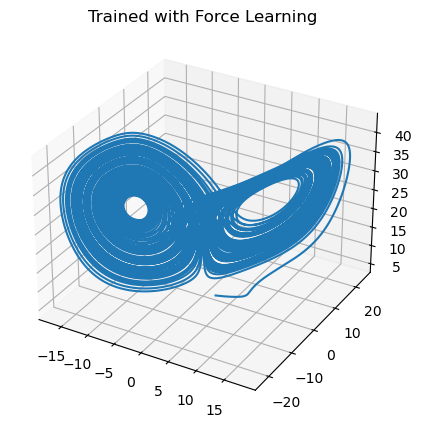

In [17]:
predict2 = trainer.predict(X, reset=True)
predict2 = bm.as_numpy(predict2)

fig = plt.figure(figsize=(5, 5))
fig.add_subplot(111, projection='3d')
plt.plot(predict2[0, :, 0], predict2[0, :, 1], predict2[0, :, 2])
plt.title('Trained with Force Learning')
plt.show()

## Back-propagation algorithm

In recent years, back-propagation has become a powerful method to train recurrent neural network. BrainPy also support trains networks with back-propagation algorithms.

In [18]:
reservoir = (bp.nn.Input(3) >>
             bp.nn.Reservoir(100))
reservoir.initialize()

In [19]:
# The reservoir node is not trainable.
# Therefore, we generate the reservoir output
# data as the input data to train readout node.

runner = bp.nn.RNNRunner(reservoir)
projections = runner.predict(X)

  0%|          | 0/99995 [00:00<?, ?it/s]

In [20]:
# For linear readout node, it is not a recurrent node.
# There is no need to keep time axis.
# Therefore, we make the original time step as the sample size.

projections = projections[0]
targets = Y[0]

In [21]:
readout = bp.nn.Dense(3, input_shape=100)
readout.initialize()

In [22]:
# Training the readout node with the back-propagation method.
# Due to the Dense node is a feedforward node, we use BPTT trainer.

trainer = bp.nn.BPFF(readout,
                     loss=bp.losses.mean_squared_error,
                     optimizer=bp.optim.Adam(lr=1e-3))
trainer

BPFF(target=Dense(name=Dense0, forwards=((None, 100),), 
      feedbacks=None, output=(None, 3)), 
	    jit={'fit': True, 'predict': True, 'loss': True}, 
	    loss=<function mean_squared_error at 0x0000021BC021BC10>, 
	    optimizer=Adam(lr=Constant(0.001), beta1=0.9, beta2=0.999, eps=1e-08))

In [23]:
trainer.fit([projections, targets],
            num_report=2000,
            num_batch=64,
            num_train=40)

Train 2000 steps, use 3.4620 s, train loss 31.42259
Train 4000 steps, use 2.4532 s, train loss 14.43684
Train 6000 steps, use 2.3870 s, train loss 10.64222
Train 8000 steps, use 2.4791 s, train loss 13.16424
Train 10000 steps, use 2.3759 s, train loss 7.0941
Train 12000 steps, use 2.3584 s, train loss 7.70877
Train 14000 steps, use 2.3648 s, train loss 8.33284
Train 16000 steps, use 2.4334 s, train loss 3.79623
Train 18000 steps, use 2.3502 s, train loss 3.86504
Train 20000 steps, use 2.3463 s, train loss 3.96748
Train 22000 steps, use 2.4486 s, train loss 3.88499
Train 24000 steps, use 2.3902 s, train loss 2.47998
Train 26000 steps, use 2.3854 s, train loss 1.69119
Train 28000 steps, use 2.3613 s, train loss 1.85288
Train 30000 steps, use 2.4531 s, train loss 1.77884
Train 32000 steps, use 2.3742 s, train loss 1.95193
Train 34000 steps, use 2.3862 s, train loss 1.6745
Train 36000 steps, use 2.4662 s, train loss 1.20792
Train 38000 steps, use 2.3957 s, train loss 1.55736
Train 40000 st

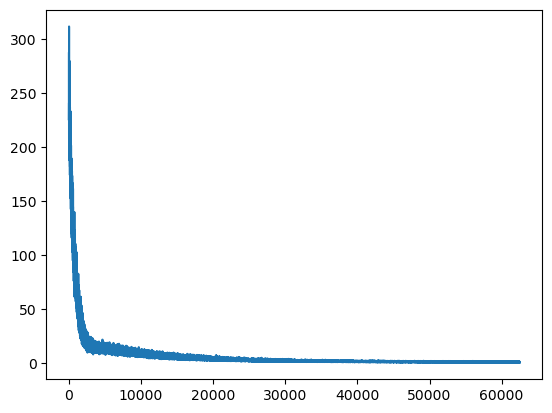

In [24]:
# plot the training loss

plt.plot(trainer.train_losses.numpy())
plt.show()

In [25]:
# Finally, let's make the full model in which
# reservoir node generates the high-dimensional
# projection data, and then the linear readout
# node readout the final value.

model = reservoir >> readout
model.initialize()

runner = bp.nn.RNNRunner(model)

  0%|          | 0/99995 [00:00<?, ?it/s]

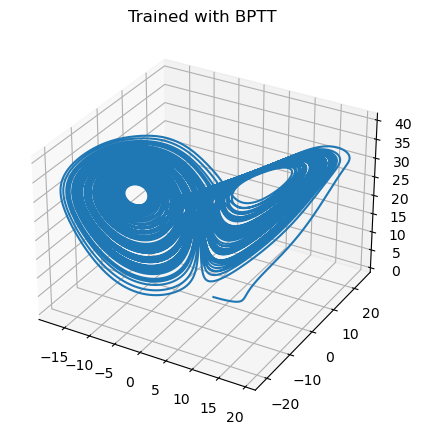

In [26]:
predict3 = runner.predict(X)
predict3 = bm.as_numpy(predict3)

fig = plt.figure(figsize=(5, 5))
fig.add_subplot(111, projection='3d')
plt.plot(predict3[0, :, 0], predict3[0, :, 1], predict3[0, :, 2])
plt.title('Trained with BPTT')
plt.show()

## Shared parameters

Sometimes, there are some global parameters which are shared across all nodes. For example, the training or testing phase control parameter ``train=True/False``. Here, we use one simple model to demonstrate how to provide shared parameters when we calling models.

In [27]:
model = (
    bp.nn.Input(1)
    >>
    bp.nn.VanillaRNN(100)
    >>
    bp.nn.Dropout(0.3)
    >>
    bp.nn.Dense(1)
)
model.initialize(3)

These shared parameters can be provided as two kinds of ways:

- When you are using the instantiated model directly, you can provide them when calling this model.

In [28]:
model(bm.random.rand(3, 1), train=True)

JaxArray([[-1.2080045],
          [-0.962251 ],
          [ 0.246601 ]], dtype=float32)

In [29]:
model(bm.random.rand(3, 1), train=False)

JaxArray([[-0.18471804],
          [-0.11392485],
          [-0.13624835]], dtype=float32)

- When you are using the structural runners like ``brainpy.nn.RNNRunner`` or ``brainpy.nn.BPTT`` trainer, you can warp all shared parameters in an argument ``shared_kwargs``.

In [30]:
runner = bp.nn.RNNRunner(model)

In [31]:
runner.predict(bm.random.random((3, 10, 1)),
               shared_kwargs={'train': True})

  0%|          | 0/10 [00:00<?, ?it/s]

JaxArray([[[-0.3159347 ],
           [-0.69149274],
           [-0.04672527],
           [ 0.03180977],
           [-0.06807568],
           [-0.13523842],
           [ 0.01571239],
           [-0.11823184],
           [ 0.12058208],
           [-0.17275347]],

          [[ 0.0180111 ],
           [-0.12634276],
           [-0.32290417],
           [-0.16321549],
           [-0.05132714],
           [ 0.08687519],
           [-0.12866825],
           [-0.3837371 ],
           [-0.3020746 ],
           [-0.1423104 ]],

          [[-0.414655  ],
           [-0.496073  ],
           [-0.4937666 ],
           [-0.04079266],
           [ 0.04316711],
           [ 0.11759105],
           [-0.59218377],
           [ 0.14002447],
           [-0.27708793],
           [-0.10970033]]], dtype=float32)

In [32]:
runner.predict(bm.random.random((3, 10, 1)),
               shared_kwargs={'train': False})

  0%|          | 0/10 [00:00<?, ?it/s]

JaxArray([[[-0.2004511 ],
           [-0.02842245],
           [-0.05291707],
           [-0.00817785],
           [-0.1658831 ],
           [-0.0154308 ],
           [-0.08032076],
           [-0.02801216],
           [-0.06928631],
           [-0.02795052]],

          [[-0.01163506],
           [-0.12711151],
           [-0.01078814],
           [-0.04324045],
           [-0.14794606],
           [-0.09333474],
           [-0.0649181 ],
           [-0.02171569],
           [-0.07023487],
           [-0.06169168]],

          [[-0.02836527],
           [-0.02502684],
           [-0.16531822],
           [-0.02565872],
           [ 0.00313345],
           [-0.02255425],
           [-0.20593695],
           [-0.11946493],
           [-0.13288933],
           [-0.07359352]]], dtype=float32)

However, it's worthy to note that ``shared_kwargs`` should only have several values. Different value of ``shared_kwargs`` will trigger recompilation. If ``shared_kwargs`` change significantly and frequently, you’d better not declare it as ``shared_kwargs``.